In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 213 GB / percent used: 15.5 %


# Snow

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Variable
var = 'snc'
table = u.get_table(var)
    
var_label = 'Snow cover extent [%]'
var_label_trends = 'Snow cover extent trends [%/dec]'
var_label_bias = 'Snow cover bias [%]'
cmap='viridis'
levels=plot.arange(0,100,10)

# Load obs snow
## NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

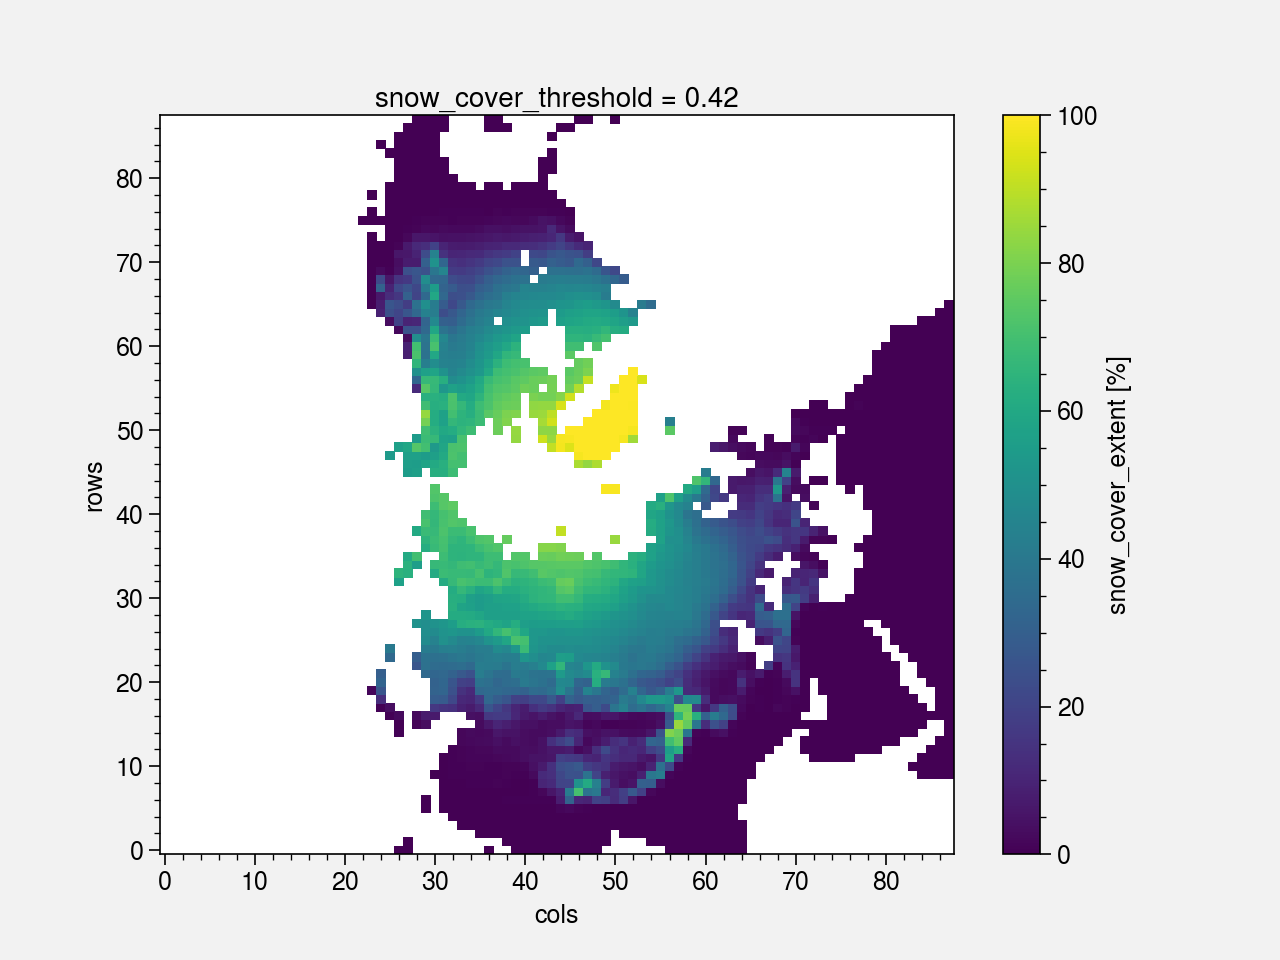

In [3]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period).mean('time')
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs_clim = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs_clim.attrs['units'] = '%'
obs_clim = obs_clim.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid
# obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True) # Resamble data per month (from per week)
obs_clim.plot()

# Load model data
Get only models with tas, ta, ps, snc, for comparisons (http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/ta-global_multimodel/list_models.ipynb)


In [4]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

list_models = ['BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CanESM5', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-CM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'SAM0-UNICON']
# list_models = ['BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-FV2']
realization = 'r1i1p1f1'

bias_snow = []
clim_snow = []

for model in list_models:
    print(model)
    institute, grid = u.select_model(model, var)
    model_clim = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', combine='by_coords'
    ).sel(time=period)[var].mean('time')
    
    # Some models have values between 0 and 1 even if units in % (ex: 'BCC-CSM2-MR', 'BCC-ESM1', 'FGOALS-f3-L')
    if model_clim.max().values <= 1:
        model_clim = model_clim*100
    
    # Regrid towards model
    regridder = xe.Regridder(obs_clim, model_clim, 'bilinear', periodic=False, reuse_weights=True)
    regridder = add_matrix_NaNs(regridder)
    obs_clim_regrid = regridder(obs_clim)
    
    clim_snow.append(model_clim)
    bias_snow.append(model_clim - obs_clim_regrid)

BCC-CSM2-MR


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_160x320.nc
BCC-ESM1


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_64x128.nc
CESM2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_192x288.nc
CESM2-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_96x144.nc
CESM2-WACCM


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_192x288.nc
CESM2-WACCM-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'snc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_96x144.nc
CanESM5
Reuse existing file: bilinear_88x88_64x128.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


EC-Earth3-Veg
Reuse existing file: bilinear_88x88_256x512.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


FGOALS-f3-L


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_192x288.nc
GFDL-CM4
Reuse existing file: bilinear_88x88_180x288.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


GISS-E2-1-G
Reuse existing file: bilinear_88x88_90x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


GISS-E2-1-G-CC
Reuse existing file: bilinear_88x88_90x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


GISS-E2-1-H
Reuse existing file: bilinear_88x88_90x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


IPSL-CM6A-LR


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_143x144.nc
MIROC6


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_128x256.nc
MPI-ESM1-2-HR


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_192x384.nc
MPI-ESM1-2-LR


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_96x192.nc
MRI-ESM2-0


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_160x320.nc
NorCPM1
Reuse existing file: bilinear_88x88_96x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


NorESM2-LM
Reuse existing file: bilinear_88x88_96x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


SAM0-UNICON


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_88x88_192x288.nc


# Tas

In [5]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Variable
var = 'tas'
table = u.get_table(var)
    
var_label = 'Near-Surface Air Temperature [°C]'
var_label_trends = 'Near-Surface Air Temperature trends [°C/dec]'
var_label_bias = 'Near-Surface Air Temperature bias [°C]'
cmap='CoolWarm'
levels=plot.arange(-30,30,5)

# Load obs tas
## cru_ts4.00
More recent version available: https://crudata.uea.ac.uk/cru/data/hrg/  
-> pas évident à télécharger encore... les netCDF ne sont pas reconnus directement, je vais rester du coup sur la version 4.00  

```bash
cdo mergetime /bdd/cru/cru_ts_4.00/data/tmp/*.nc /data/mlalande/CRU/tmp/cru_ts4.00.1901.2015.tmp.dat.nc 
```

(pas plus rapide...)

Du coup je vais rester avec le open_mfdataset (même si le time n'est pas bien reconnu d'où le découpage à la main avec le isel)

See: http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Temperature.ipynb

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


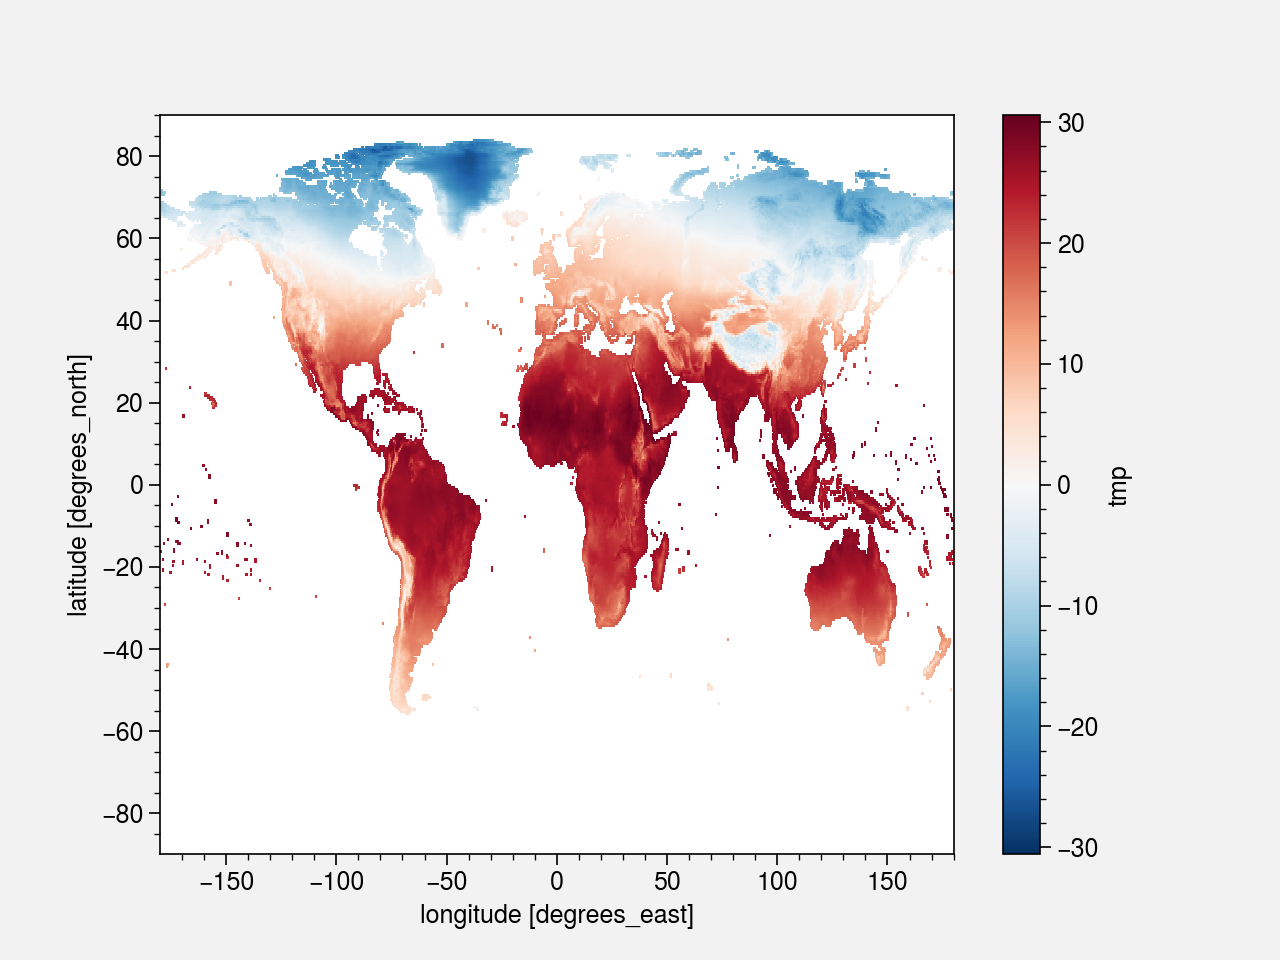

In [6]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs_clim = xr.open_mfdataset(
    '/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.*.tmp.dat.nc', combine='nested', concat_dim='time'
).isel(time=slice(1080,1488)).tmp.mean('time')
obs_clim.plot()

In [7]:
list_models = ['BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CanESM5', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-CM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'SAM0-UNICON']
# list_models = ['BCC-CSM2-MR', 'BCC-ESM1', 'CESM2', 'CESM2-FV2']
realization = 'r1i1p1f1'

bias_tas = []

for model in list_models:
    print(model)
    institute, grid = u.select_model(model, var)
    model_clim = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', combine='by_coords'
    ).sel(time=period)[var].mean('time')-273.15
    
    # Regrid towards model
    regridder = xe.Regridder(obs_clim, model_clim, 'bilinear', periodic=True, reuse_weights=True)
    obs_clim_regrid = regridder(obs_clim)
    
    bias_tas.append(model_clim - obs_clim_regrid)

BCC-CSM2-MR
Reuse existing file: bilinear_360x720_160x320_peri.nc
BCC-ESM1
Reuse existing file: bilinear_360x720_64x128_peri.nc
CESM2
Reuse existing file: bilinear_360x720_192x288_peri.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Reuse existing file: bilinear_360x720_96x144_peri.nc
CESM2-WACCM
Reuse existing file: bilinear_360x720_192x288_peri.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Reuse existing file: bilinear_360x720_96x144_peri.nc
CanESM5
Reuse existing file: bilinear_360x720_64x128_peri.nc
EC-Earth3-Veg
Reuse existing file: bilinear_360x720_256x512_peri.nc
FGOALS-f3-L
Reuse existing file: bilinear_360x720_180x288_peri.nc
GFDL-CM4
Reuse existing file: bilinear_360x720_180x288_peri.nc
GISS-E2-1-G
Reuse existing file: bilinear_360x720_90x144_peri.nc
GISS-E2-1-G-CC
Reuse existing file: bilinear_360x720_90x144_peri.nc
GISS-E2-1-H
Reuse existing file: bilinear_360x720_90x144_peri.nc
IPSL-CM6A-LR
Reuse existing file: bilinear_360x720_143x144_peri.nc
MIROC6
Reuse existing file: bilinear_360x720_128x256_peri.nc
MPI-ESM1-2-HR
Reuse existing file: bilinear_360x720_192x384_peri.nc
MPI-ESM1-2-LR
Reuse existing file: bilinear_360x720_96x192_peri.nc
MRI-ESM2-0
Reuse existing file: bilinear_360x720_160x320_peri.nc
NorCPM1
Reuse existing file: bilinear_360x720_142x144_peri.nc
NorESM2-LM
Reuse existing file: bilinear_360x720_96x144_peri.nc
SAM0-UNICON
Reuse existing file: bili

# Plot clim snow

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: 

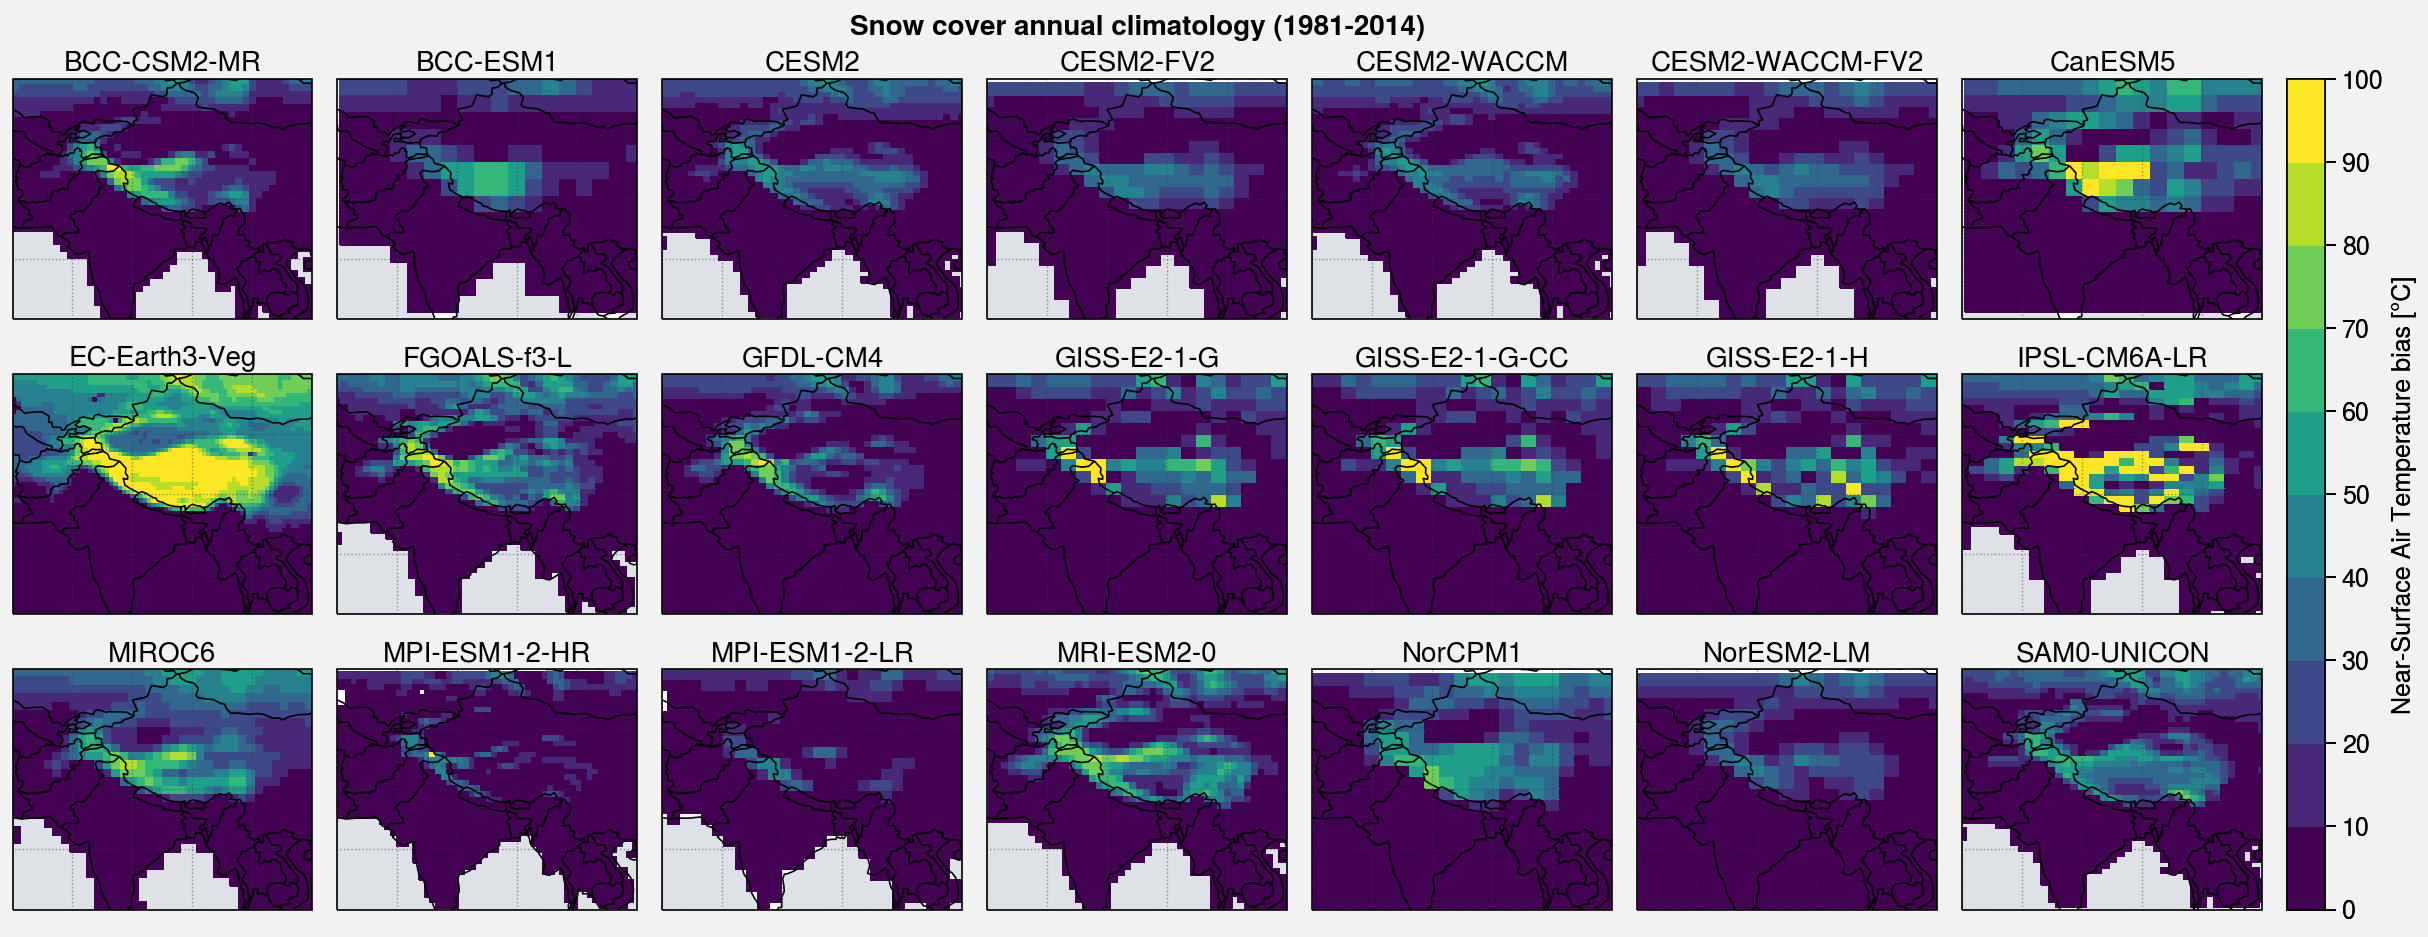

In [8]:
f, axs = plot.subplots(proj='cyl', ncols=7, nrows=3, axwidth=1.5)

for i, ax in enumerate(axs):
    #Plot
    m = axs[i].pcolormesh(clim_snow[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap='viridis', levels=plot.arange(0,100,10))
    axs[i].format(title=list_models[i])
    
f.colorbar(m, label=var_label_bias, loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Snow cover annual climatology (1981-2014)",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

In [35]:
x = clim_snow[0].values.flatten()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [36]:
x = x[~np.isnan(x)]

In [40]:
len(x)

19598

In [26]:
clim_snow[0].where(clim_snow[0] > 10).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

TypeError: dropna() missing 1 required positional argument: 'dim'

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return

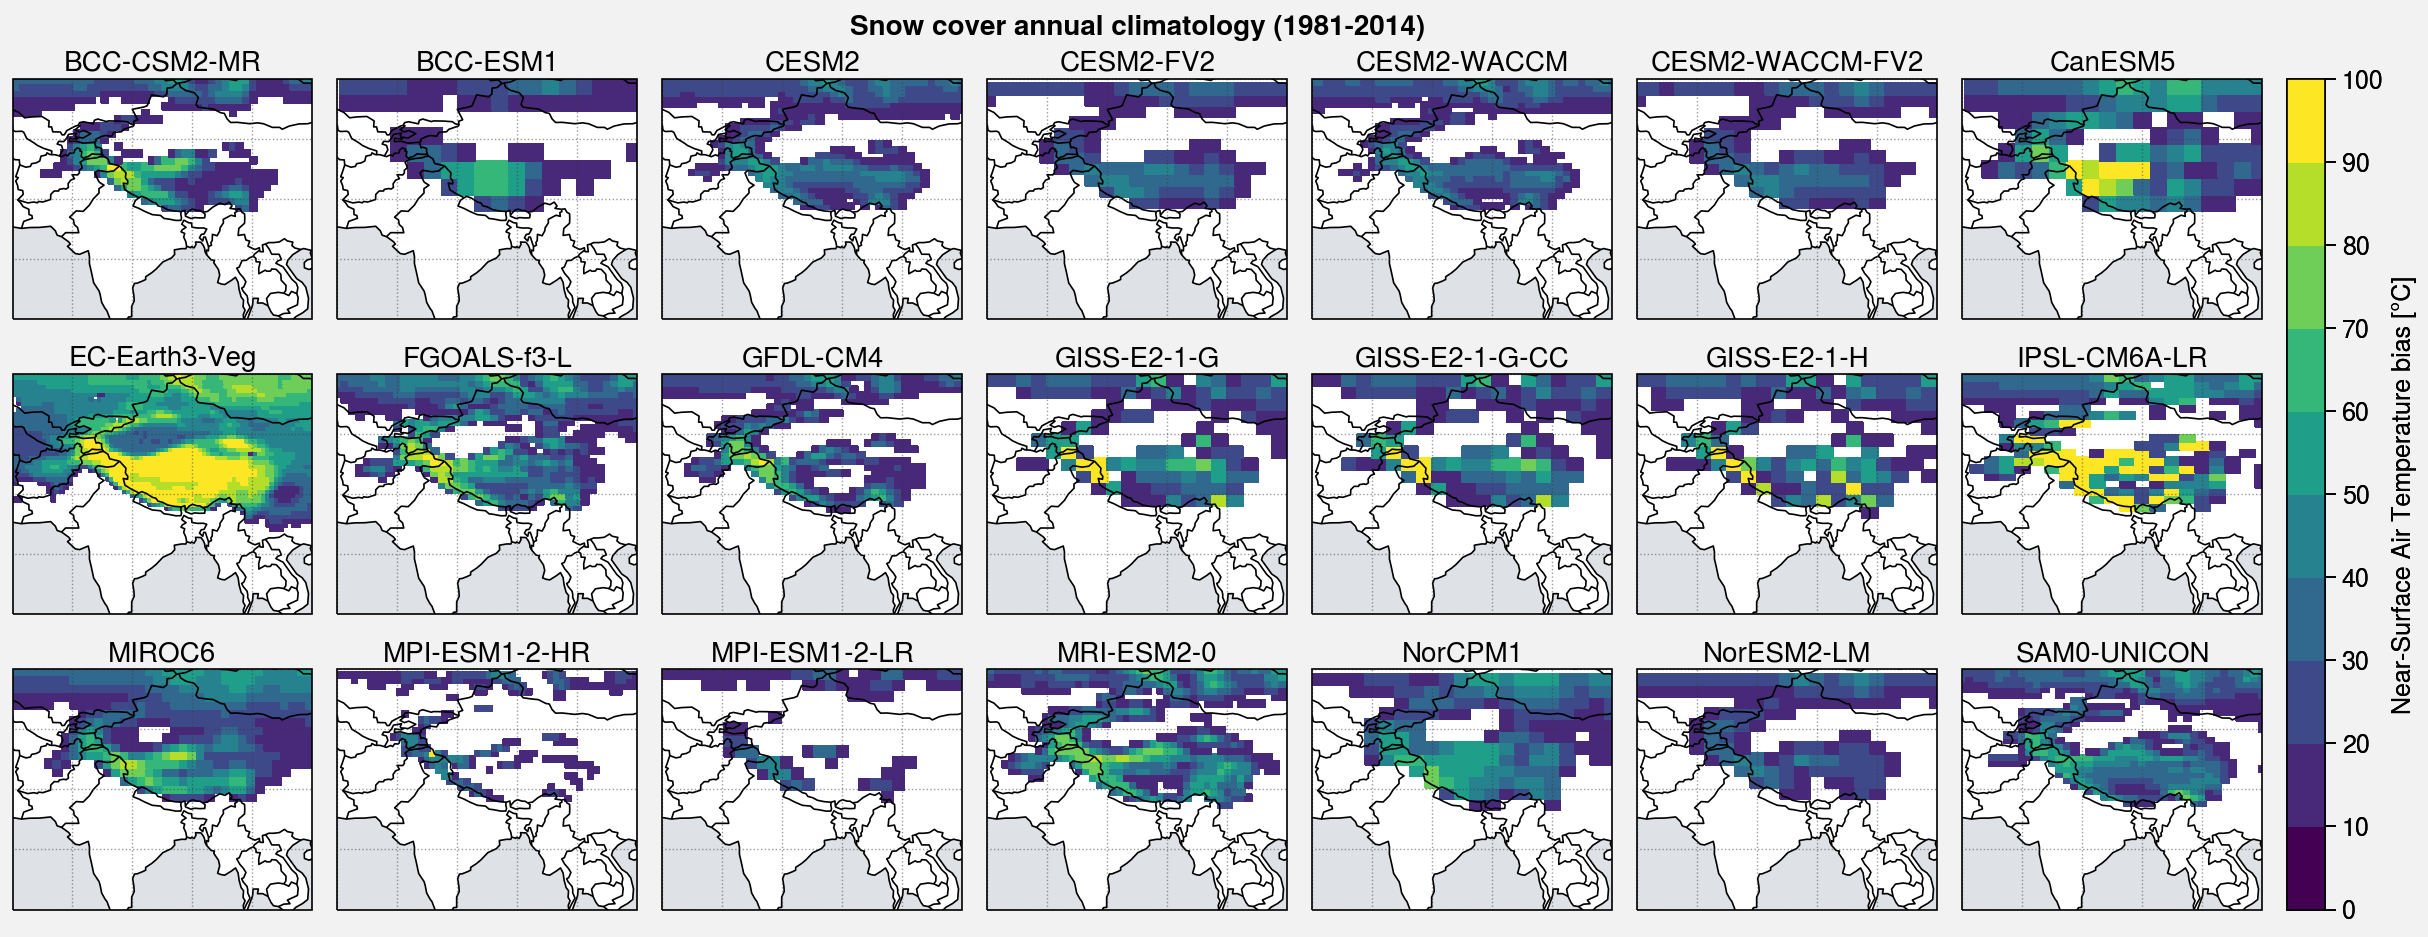

In [9]:
f, axs = plot.subplots(proj='cyl', ncols=7, nrows=3, axwidth=1.5)

for i, ax in enumerate(axs):
    #Plot
    m = axs[i].pcolormesh(clim_snow[i].where(clim_snow[i] > 10).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap='viridis', levels=plot.arange(0,100,10))
    axs[i].format(title=list_models[i])
    
f.colorbar(m, label=var_label_bias, loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Snow cover annual climatology (1981-2014)",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: 

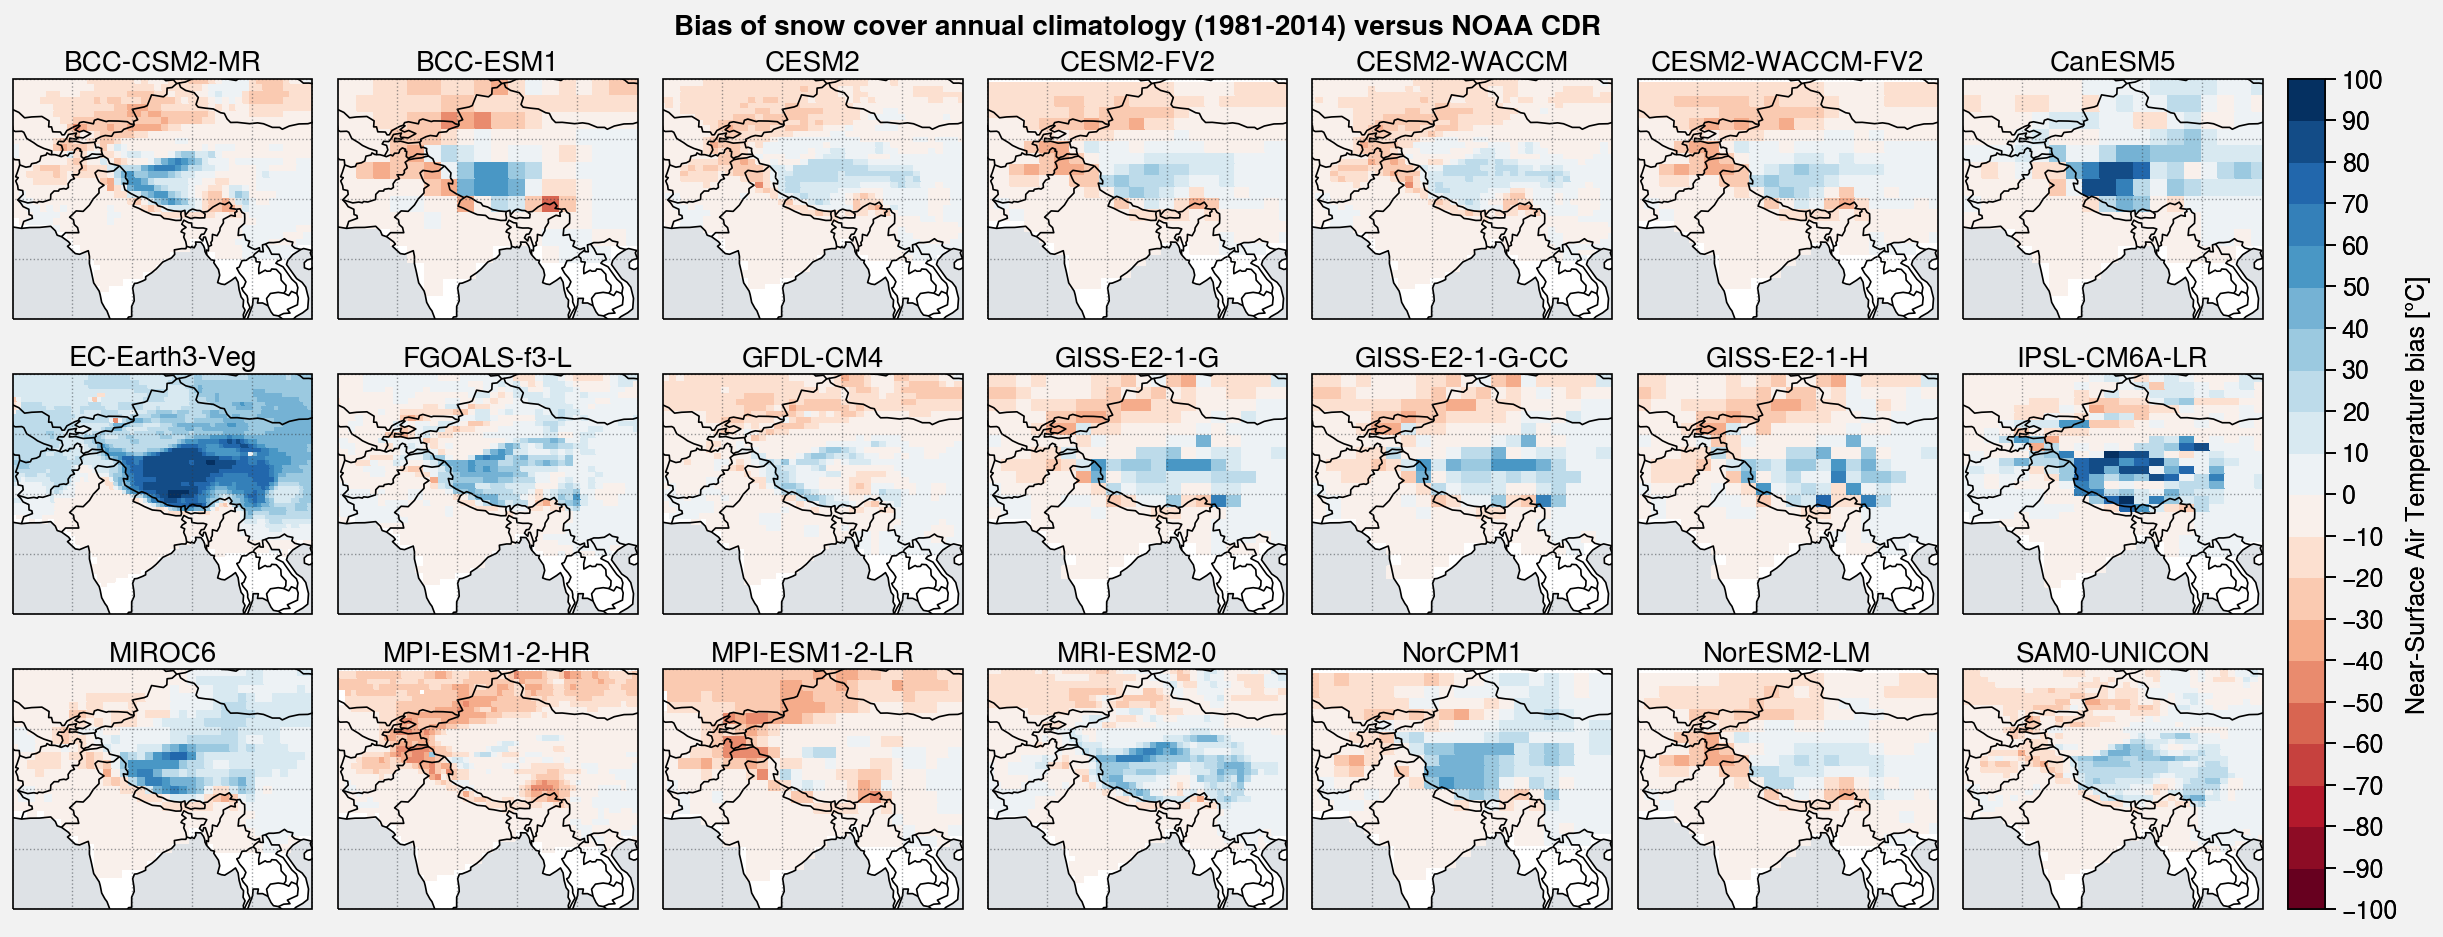

In [10]:
f, axs = plot.subplots(proj='cyl', ncols=7, nrows=3, axwidth=1.5)

for i, ax in enumerate(axs):
    #Plot
    m = axs[i].pcolormesh(bias_snow[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap='RdBu', levels=plot.arange(-100,100,10))
    axs[i].format(title=list_models[i])
    
    
f.colorbar(m, label=var_label_bias, loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Bias of snow cover annual climatology (1981-2014) versus NOAA CDR",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: 

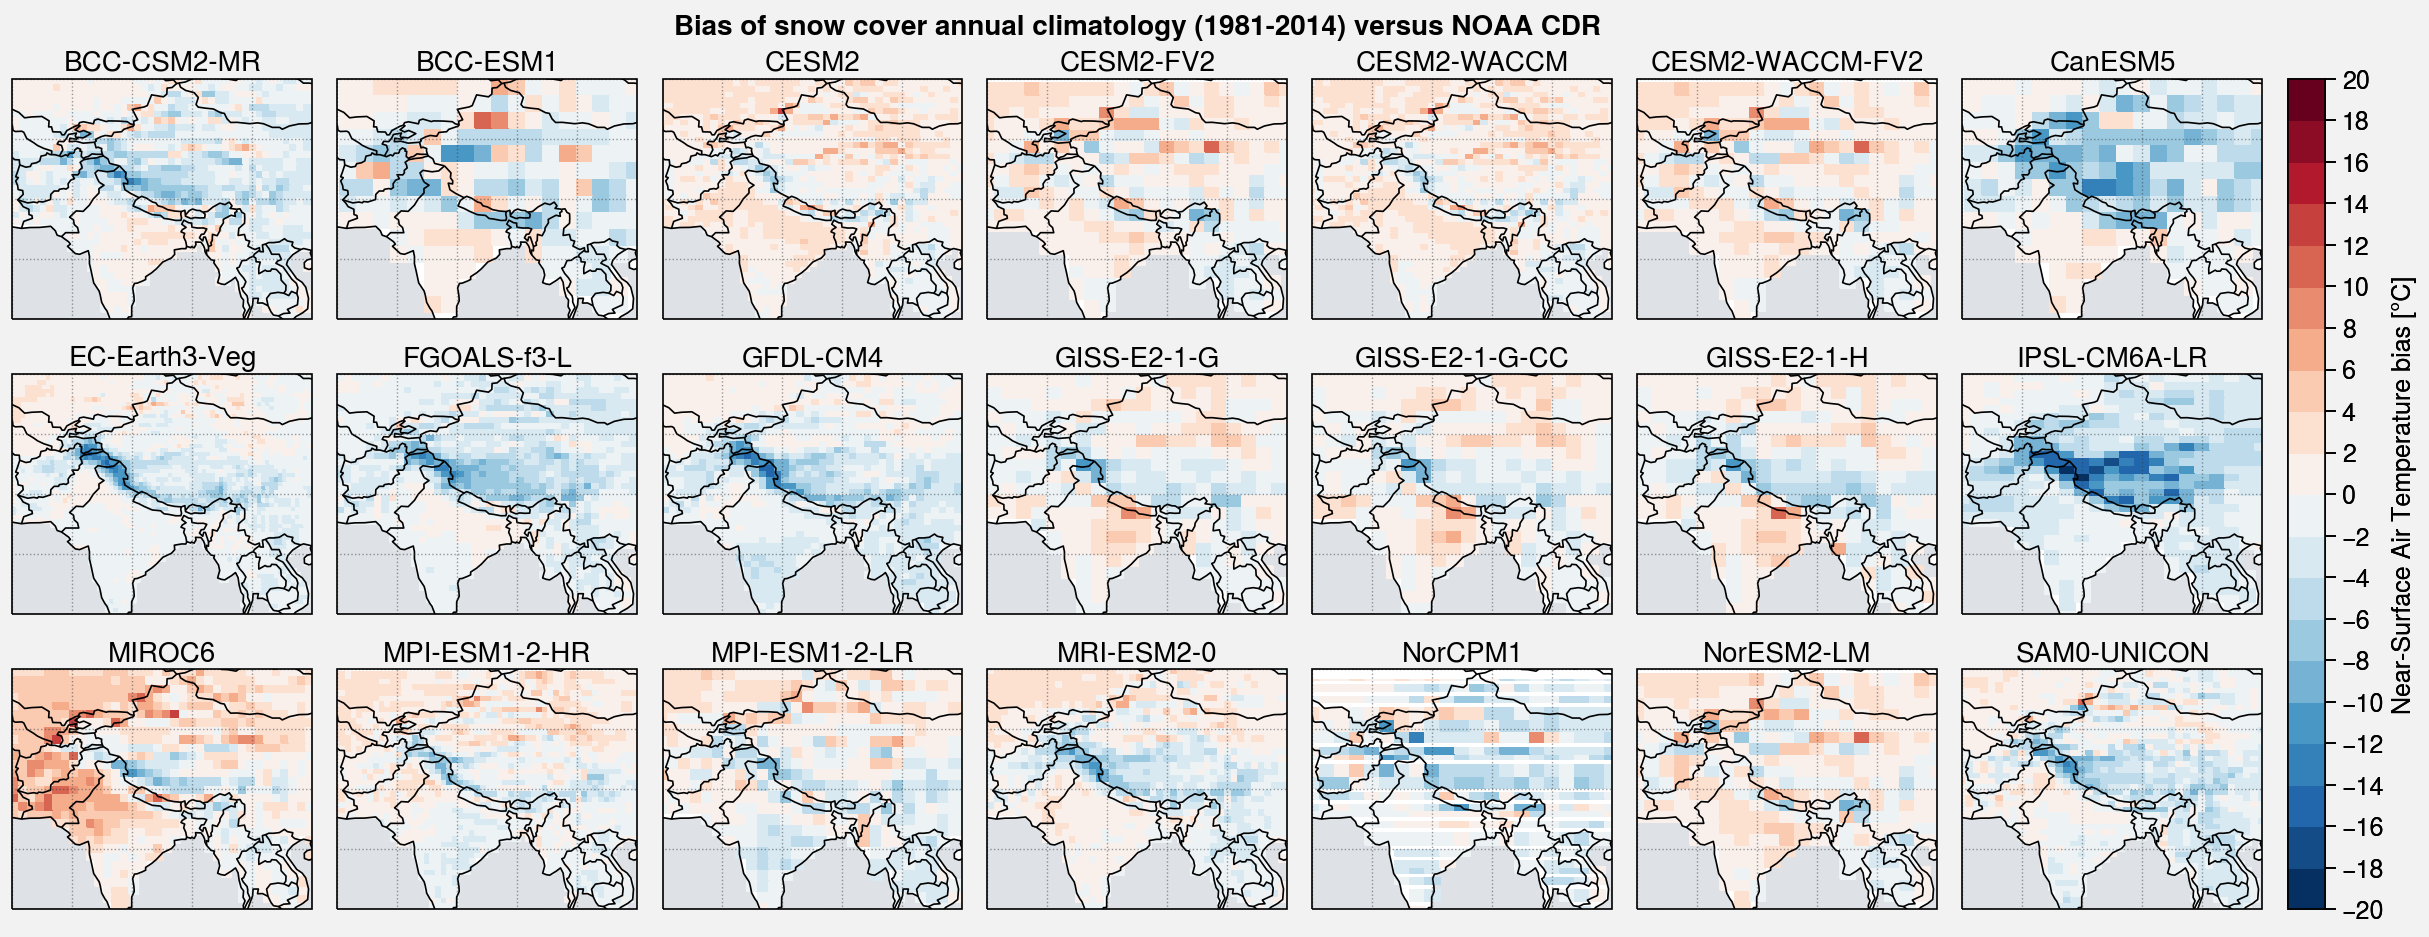

In [13]:
f, axs = plot.subplots(proj='cyl', ncols=7, nrows=3, axwidth=1.5)

for i, ax in enumerate(axs):
    #Plot
    m = axs[i].pcolormesh(bias_tas[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), cmap='RdBu_r', levels=plot.arange(-20,20,2))
    axs[i].format(title=list_models[i])
    
    
f.colorbar(m, label=var_label_bias, loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Bias of snow cover annual climatology (1981-2014) versus NOAA CDR",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)